<a href="https://colab.research.google.com/github/codingshinobi/Deloitte_Machinehack_Loan_Default_prediction/blob/main/Copy_of_deloitte_bank_loan_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Basics



In [ ]:
#pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import  classification_report, confusion_matrix, make_scorer
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
#training dataset
train = pd.read_csv(r"D:\DATASETS\DELOITTE\Participants_Data_PLD\train.csv")

In [ ]:
train.shape

(67463, 35)

In [ ]:
# test dataset
test = pd.read_csv(r"D:\DATASETS\DELOITTE\Participants_Data_PLD\test.csv")

In [ ]:
test.shape

(28913, 35)

In [ ]:
train.head()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,...,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,...,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,...,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,...,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,...,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,...,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


In [ ]:
train['Loan Status'].value_counts()

0    61222
1     6241
Name: Loan Status, dtype: int64

This dataset is an imbalanced dataset.

## Feature Engineering

In [ ]:
# magic feature
train['Initial List Status'].value_counts()

w    36299
f    31164
Name: Initial List Status, dtype: int64

In [ ]:
train['Verification Status'].value_counts()

Source Verified    33036
Verified           18078
Not Verified       16349
Name: Verification Status, dtype: int64

In [ ]:
train['Employment Duration'].value_counts()

MORTGAGE    36351
RENT        24150
OWN          6962
Name: Employment Duration, dtype: int64

In [ ]:
train['Grade'].value_counts()

C    19085
B    18742
A    12055
D     8259
E     6446
F     2246
G      630
Name: Grade, dtype: int64

In [ ]:
train= train.fillna(0)

In [ ]:
# Basic Feature engg

train['revolving bal/ revolving util']= train['Revolving Balance']/train['Revolving Utilities']


# Complex feature engg
train['total_debt'] = train['Loan Amount']+train['Funded Amount']
train['Inv_approved_amt'] = train['Funded Amount'] - train['Funded Amount Investor']
train['Total_revenue'] = train['Total Received Interest'] + train['Total Received Late Fee'] + train['Recoveries']+ train['Collection Recovery Fee']
train['Ave_ac_bal']= train['Total Current Balance']/ train['Total Accounts']
train['Ave_revolving bal'] = train['Total Revolving Credit Limit']/ train['Total Accounts']
train['Usable credit limit'] = (train['Revolving Balance']+ train['Total Revolving Credit Limit'])/ train['Term']
train['Credit_score'] = (0.35*train['Last week Pay']+ 0.30*train['Total Collection Amount']+ 0.15*train['Total Accounts']+ 0.10*train['Open Account']+ 0.10*train['Revolving Balance'])


In [ ]:
# test dataset

# Basic Feature engg

test['revolving bal/ revolving util']= test['Revolving Balance']/test['Revolving Utilities']


# Complex feature engg
test['total_debt'] = test['Loan Amount']+test['Funded Amount']
test['Inv_approved_amt'] = test['Funded Amount'] - test['Funded Amount Investor']
test['Total_revenue'] = test['Total Received Interest'] + test['Total Received Late Fee'] + test['Recoveries']+ test['Collection Recovery Fee']
test['Ave_ac_bal']= test['Total Current Balance']/ test['Total Accounts']
test['Ave_revolving bal'] = test['Total Revolving Credit Limit']/ test['Total Accounts']
test['Usable credit limit'] = (test['Revolving Balance']+ test['Total Revolving Credit Limit'])/ test['Term']
test['Credit_score'] = (0.35*test['Last week Pay']+ 0.30*test['Total Collection Amount']+ 0.15*test['Total Accounts']+ 0.10*test['Open Account']+ 0.10*test['Revolving Balance'])



In [ ]:
print(train.shape)
print(test.shape)

(67463, 43)
(28913, 43)


## EDA


In [ ]:
#pip install pandas-profiling

In [ ]:
#from pandas_profiling import ProfileReport
#design_report = ProfileReport(train)
#design_report.to_file(output_file='report.html')

In [ ]:
train.describe().T.round()

,count,mean,std,min,25%,50%,75%,max
ID,67463.0,25627608.0,21091554.0,1297933.0,6570288.0,17915646.0,42715208.0,72245779.0
Loan Amount,67463.0,16849.0,8368.0,1014.0,10012.0,16073.0,22106.0,35000.0
Funded Amount,67463.0,15771.0,8151.0,1014.0,9266.0,13042.0,21793.0,34999.0
Funded Amount Investor,67463.0,14622.0,6785.0,1115.0,9832.0,12794.0,17808.0,35000.0
Term,67463.0,58.0,3.0,36.0,58.0,59.0,59.0,59.0
Interest Rate,67463.0,12.0,4.0,5.0,9.0,11.0,14.0,27.0
Home Ownership,67463.0,80542.0,45029.0,14574.0,51690.0,69336.0,94623.0,406562.0
Debit to Income,67463.0,23.0,8.0,1.0,17.0,23.0,30.0,40.0
Delinquency - two years,67463.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0
Inquires - six months,67463.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


<AxesSubplot:>

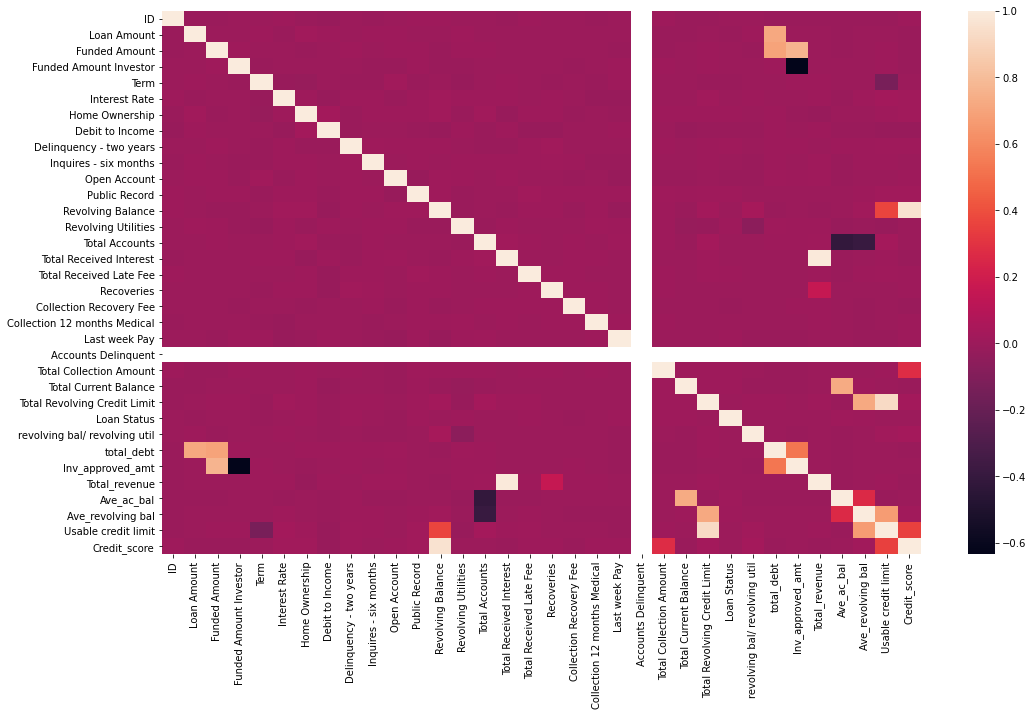

In [ ]:
sns.color_palette("Set2")
plt.figure(figsize=(17,10))
sns.heatmap(train.corr())

<AxesSubplot:xlabel='Home Ownership', ylabel='Employment Duration'>

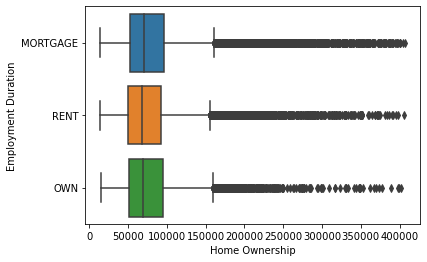

In [ ]:
sns.boxplot(x='Home Ownership', y='Employment Duration', data=train)

In [ ]:
train['Public Record'].value_counts()

0    62871
1     4133
2      200
4      184
3       75
Name: Public Record, dtype: int64

In [ ]:
train.groupby('Loan Status').mean().T.round(2)

Loan Status,0,1
ID,25624430.71,25658773.35
Loan Amount,16860.85,16731.67
Funded Amount,15767.05,15805.42
Funded Amount Investor,14622.00,14619.87
Term,58.18,58.14
Interest Rate,11.84,11.88
Home Ownership,80488.08,81065.54
Debit to Income,23.31,23.22
Delinquency - two years,0.32,0.35
Inquires - six months,0.15,0.15


## Data preprocessing

In [ ]:
# select numeric columns
df_numeric = train.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['ID' 'Loan Amount' 'Funded Amount' 'Funded Amount Investor' 'Term'
 'Interest Rate' 'Home Ownership' 'Debit to Income'
 'Delinquency - two years' 'Inquires - six months' 'Open Account'
 'Public Record' 'Revolving Balance' 'Revolving Utilities'
 'Total Accounts' 'Total Received Interest' 'Total Received Late Fee'
 'Recoveries' 'Collection Recovery Fee' 'Collection 12 months Medical'
 'Last week Pay' 'Accounts Delinquent' 'Total Collection Amount'
 'Total Current Balance' 'Total Revolving Credit Limit' 'Loan Status'
 'revolving bal/ revolving util' 'total_debt' 'Inv_approved_amt'
 'Total_revenue' 'Ave_ac_bal' 'Ave_revolving bal' 'Usable credit limit'
 'Credit_score']


In [ ]:
# select non numeric columns
df_non_numeric = train.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

['Batch Enrolled' 'Grade' 'Sub Grade' 'Employment Duration'
 'Verification Status' 'Payment Plan' 'Loan Title' 'Initial List Status'
 'Application Type']


In [ ]:
train = train.drop(columns= ['Accounts Delinquent', 'Batch Enrolled'], axis=1)
test = test.drop(columns= ['Accounts Delinquent', 'Batch Enrolled'], axis=1)

In [ ]:
train.shape

(67463, 41)

In [ ]:
test.shape

(28913, 41)

In [ ]:
train = train.drop(columns= ['Application Type', 'Payment Plan', 
                             'Sub Grade', 'Loan Title'], axis=1)
test = test.drop(columns= ['Application Type', 'Payment Plan', 
                             'Sub Grade', 'Loan Title'], axis=1)

In [ ]:
df= train
encoder = LabelEncoder()
df['Grade'] = encoder.fit_transform(df['Grade'])
df['Employment Duration'] = encoder.fit_transform(df['Employment Duration'])
df['Verification Status'] = encoder.fit_transform(df['Verification Status'])
df['Initial List Status'] = encoder.fit_transform(df['Initial List Status'])
df['Collection 12 months Medical'] =encoder.fit_transform(df['Collection 12 months Medical'])

In [ ]:
df1 = test
df1['Grade'] = encoder.fit_transform(df1['Grade'])
df1['Employment Duration'] = encoder.fit_transform(df1['Employment Duration'])
df1['Verification Status'] = encoder.fit_transform(df1['Verification Status'])
df1['Initial List Status'] = encoder.fit_transform(df1['Initial List Status'])
df1['Collection 12 months Medical'] =encoder.fit_transform(df1['Collection 12 months Medical'])

In [ ]:
df= df.fillna(0)
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df1=df1.fillna(0)

In [ ]:
df.shape

(67463, 37)

In [ ]:
df1.shape

(28913, 37)

Let's check the impact of the new features.

<AxesSubplot:>

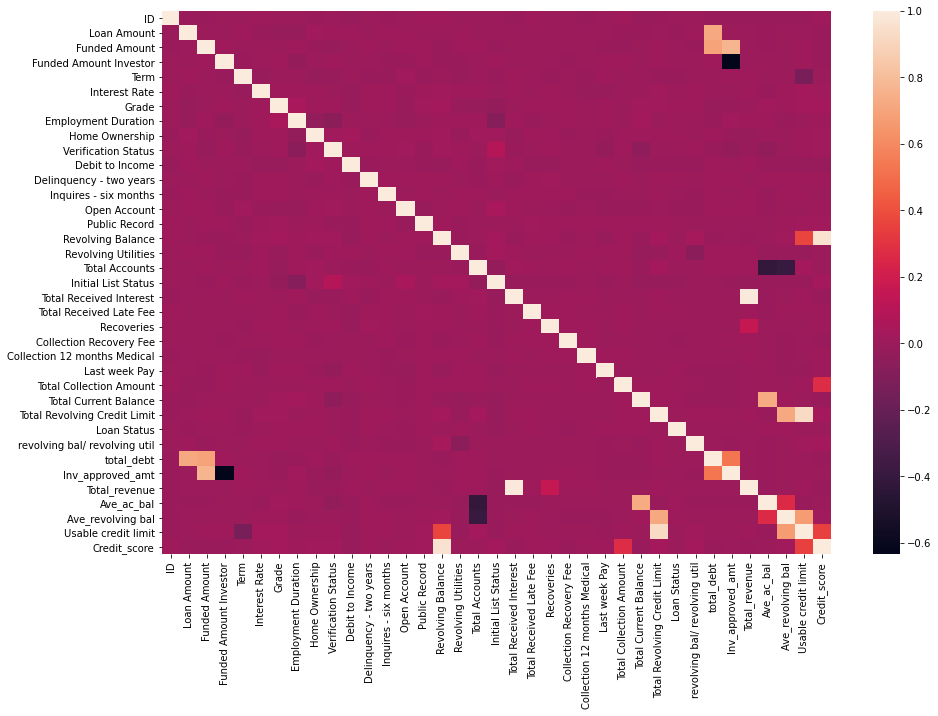

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr())

As we can see that we have 234 columns now after one hot encoding the categorical values. This many features may slow down the algorithm speeds and therefore we will delete redundant features and use dimensionality reduction techniques to decrease the number of dimensions too.

In [ ]:
# scaling the features
X = df.drop(columns=['ID', 'Loan Status'], axis=1)
y = df['Loan Status']

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
X1 = df1.drop(columns=['ID', 'Loan Status'], axis=1)
X1 = StandardScaler().fit_transform(X1)

In [ ]:
X.shape

(67463, 35)

In [ ]:
X1.shape

(28913, 35)

##Modelling and Evaluation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, train_size= 0.2, random_state= 42)

In [ ]:
y_test = LabelBinarizer().fit_transform(y_test)

In [ ]:
# Baseline model
catboost1 = CatBoostClassifier(iterations=2000)
catboost1.fit(X_train, y_train)

In [ ]:
y_pred1 = catboost1.predict_proba(X_test)

In [ ]:
def logloss(y_true, y_pred, eps=1e-15):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -(y_true * np.log(y_pred)).sum(axis=1).mean()

In [ ]:
log_loss(y_test, y_pred1)

0.3152149459587014

In [ ]:
# with changing the weights
catboost2 = CatBoostClassifier(class_weights= (9.8,1), iterations= 2000)
catboost2.fit(X_train, y_train)
y_pred2 = catboost2.predict_proba(X_test)

In [ ]:
log_loss(y_test, y_pred2)

0.43059705206756504

In [ ]:
catboost2.get_all_params()

# Imblearn

As the the dataset is hugely imbalanced we need to use sampling techniques to balance the labels.

It's clear from the above exercises tha the dataset is hugely imbalanced and we need to do something to make it more balanced. So, we will try with imblearn and see what happens. Let's start with SMOTE and then follow it with ADAYSN.

In [ ]:
from collections import Counter

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN

Using SMOTEEN

In [ ]:
sme = SMOTEENN(random_state=42)
X_res, y_res = sme.fit_resample(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size= 0.2, random_state= 42)
catboost1.fit(X_train, y_train)
ypred = cat_boost.predict_proba(X_test)

In [ ]:
y_test = LabelBinarizer().fit_transform(y_test)

In [ ]:
log_loss(y_test, ypred)

0.21940878474537365

In [ ]:
# feauture importances
plt.figure(figsize=(10,10))
fimpo = pd.Series(catboost1.feature_importances_, index = X_train.columns).plot(kind = 'barh')

SMOTETomek

In [ ]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 61220, 1: 61220})


In [ ]:
cat_boost = CatBoostClassifier(iterations=2000)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size= 0.2, random_state= 42)

In [ ]:
y_test = LabelBinarizer().fit_transform(y_test)

In [ ]:
catboost3 = CatBoostClassifier(iterations=2000, learning_rate= 0.1, l2_leaf_reg= 2.5, 
                               random_seed= 0, bootstrap_type='Bernoulli', subsample=0.7,
                               random_strength=0.5, depth= 10)
catboost3.fit(X_train, y_train)
y_pred = catboost1.predict_proba(X_test)

In [ ]:
print('All_shapes',
      "X_train:", X_train.shape,
      'y_train:', y_train.shape,
      'X_test:', X_test.shape,
      'y_test:', y_test.shape,
      'y_pred:', y_pred.shape)

All_shapes X_train: (24488, 35) y_train: (24488,) X_test: (97952, 35) y_test: (97952, 1) y_pred: (97952, 2)


In [ ]:
log_loss(y_test, y_pred)

0.1992535903765612

In [ ]:
catboost1.get_all_params()

In [ ]:
from sklearn.model_selection import learning_curve

Using smotetomek we get a logloss of 1.912 and with removed features we get 2.03053.

In [ ]:
np.any(np.isinf(X1))

False

In [ ]:
X1_scaled = StandardScaler().fit_transform(X1)

In [ ]:
#testing on test dataset
predictions = catboost3.predict_proba(X1)
submission_file = pd.read_csv(r"D:\DATASETS\DELOITTE\Participants_Data_PLD\submission.csv")
submission_file['Loan Status']= predictions
submission_file['Loan Status'].value_counts()

0.005176    1
0.000366    1
0.001116    1
0.000365    1
0.000281    1
           ..
0.018646    1
0.000017    1
0.002226    1
0.000152    1
0.000317    1
Name: Loan Status, Length: 28913, dtype: int64

In [ ]:
submission_file.to_csv('my_file.csv', index= False)

#Other Models

In [ ]:
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier()
eec.fit(X_train, y_train)
y_pred = eec.predict_proba(X_test)

In [ ]:
print(log_loss(y_test, y_pred))

0.6769598504401101


In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict_proba(X_test)
print(log_loss(y_test, y_pred))

5.952748520692606


In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
ypred = forest.predict_proba(X_test)
print(log_loss(y_test,ypred))

0.33823424206891


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
ypred = gb.predict(X_test)
print(log_loss(y_test,ypred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     54636
           1       0.88      1.00      0.94     42902

    accuracy                           0.94     97538
   macro avg       0.94      0.95      0.94     97538
weighted avg       0.95      0.94      0.94     97538

2.0651929053107656


In [ ]:
from sklearn.ensemble import StackingClassifier
estimators = ['forest', forest, 'EEC', eec,
              'GB', gb]
stacking = StackingClassifier(estimators = estimators, final_estimator= catboost1)